# many to many지만 입력값이 모두 입력된 뒤에 hidden state를 거쳐서 output이 나오는 seq2seq구조임 
# **(문장을 전부 확인하고 해석을 한다는 아이디어에서 기인)** <- 이것이 rnn과 큰 차이

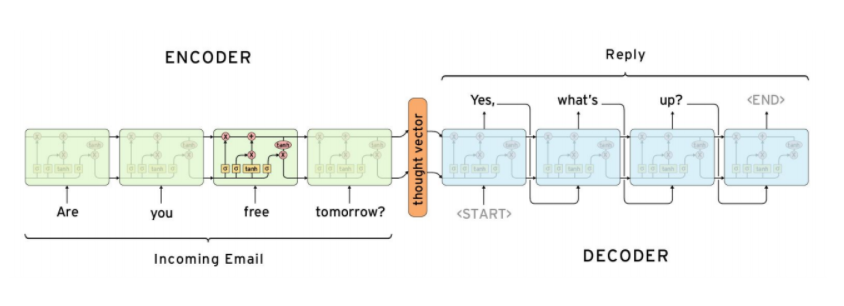

In [1]:
# main reference
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
raw = ["I feel hungry.	나는 배가 고프다.",
       "Pytorch is very easy.	파이토치는 매우 쉽다.",
       "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
       "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다."]

In [5]:
# fix token for "start of sentence" and "end of sentence"

SOS_token = 0 # start of sentences -> 디코더의 시작을 알림
EOS_token = 1 # end of sentences -> 디코더의 종료를 알림

In [6]:
# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

In [7]:
# filter out the long sentence from source and target data
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

In [8]:
filter_pair(raw, 10, 12)

True

In [9]:
# read and preprocess the corpus data

# 원문,제한길이를 인자로 source/target 텍스트로 분리해준다.
    
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")]) # tab으로 분리(raw가 영어/한글이 tab으로 나뉘어 있음)
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab() # vocab클래스로 단어의 개수 딕셔너리 등등을 만들어 넣어줌
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab) # 영어 원문 단어 개수 (공백포함)
    print("target vocab size =", target_vocab.n_vocab) # 해석본 단어 개수 (공백포함)

    return pairs, source_vocab, target_vocab

In [10]:
a=preprocess(raw,10,12)

a

reading corpus...
Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 17
target vocab size = 13


([['i feel hungry.', '나는 배가 고프다.'],
  ['pytorch is very easy.', '파이토치는 매우 쉽다.'],
  ['pytorch is a framework for deep learning.', '파이토치는 딥러닝을 위한 프레임워크이다.'],
  ['pytorch is very clear to use.', '파이토치는 사용하기 매우 직관적이다.']],
 <__main__.Vocab at 0x1f1703dab08>)

In [11]:
# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size) # 데이터를 히든 사이즈만큼 임베딩(벡터로 차원 줄임)
        self.gru = nn.GRU(hidden_size, hidden_size) # gru 모델 정의 자체는 매우 쉬움

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

In [12]:
type(a)

tuple

In [13]:
# declare simple decoder

# 인코더로 데이터를 압축하여 gru에서 나온 값이 디코더에서는 hidden state로 입력되고, 입력값도 다시 들어가서 최종 번역본을 예측한다.

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size) # input 벡터가 들어가야 하기 때문에 입력값을 똑같이 임베딩 해준다.
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size) # 디코더에서는 최종 출력값을 위해 linear를 넣어준다. 
        self.softmax = nn.LogSoftmax(dim=1) # 확률값으로 뽑아내기위해 소프트맥스 함수 이용

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden) # gru 모델에 넣어줌.
        x = self.softmax(self.out(x[0])) # soft max에 넣어서 확률값 도출
        return x, hidden

In [14]:
# convert sentence to the index tensor

# sentence들을 원 핫 벡터 후 텐서화 해주는 함수 정의

def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

In [15]:
# training seq2seq
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)] # 데이터를 배치 사이즈만큼 랜덤하게 뽑아내기 위함
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch] # 텐서화한 원문을 training batch 적용
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch] # 텐서화한 번역문을 training batch 적용

    criterion = nn.NLLLoss() # negative log likelihood(음의 로그 함수)이용

    for i in range(1, n_iter + 1): # 에포크 for문이라고 생각
        source_tensor = training_source[i - 1] # 입력 데이터를 여기서 next해줌
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device) # 일단 0벡터로 첫 임의의 히든 스테이트 값을 만들어줌

        encoder_optimizer.zero_grad() # 인코더, 디코더 각각 학습 실행
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        # 인코더
        for enc_input in range(source_length): # 1 에포크 내에 인코더를 전부 거쳐야함
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device) # start of token을 넣어준다. 
        decoder_hidden = encoder_hidden # 인코더의 hidden state를 디코더로 입력해준다. 

        # 디코더
        for di in range(target_length): # 1 에포크 내에서 인코더를 전부 거치기
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing(이미 정답 레이블을 인풋으로 넣어서 하는 방식, 랜덤 함수로 비율 조절이 가능하다)

# 에포크 for문에 걸어줘야 함 -> 인코더와 디코더를 전부 거치고 난 뒤에야 backward를 해야함 
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

In [16]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0]) # 영어 원문
        print("=", pair[1]) # 번역문
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length): 
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

            # 학습한 디코더에 다시 입력값 입력
        decoder_input = torch.Tensor([[SOS_token]], device=device).long() # 디코더 인풋 값
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence) # 예측 번역문
        print("")

In [17]:
# declare max length for sentence
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [18]:
# preprocess the corpus

load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 17
target vocab size = 13
['i feel hungry.', '나는 배가 고프다.']


In [19]:
# declare the encoder and the decoder

enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [20]:
# train seq2seq model

train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 500, print_every=100)

[100 - 20.0%] loss = 2.1766
[200 - 40.0%] loss = 1.5149
[300 - 60.0%] loss = 1.0559
[400 - 80.0%] loss = 0.7158
[500 - 100.0%] loss = 0.5107


In [21]:
# check the model with given data
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)

> i feel hungry.
= 나는 배가 고프다.
< 나는 배가 고프다. <EOS>

> pytorch is very easy.
= 파이토치는 매우 쉽다.
< 파이토치는 매우 쉽다. <EOS>

> pytorch is a framework for deep learning.
= 파이토치는 딥러닝을 위한 프레임워크이다.
< 파이토치는 사용하기 매우 직관적이다. <EOS>

> pytorch is very clear to use.
= 파이토치는 사용하기 매우 직관적이다.
< 파이토치는 매우 쉽다. <EOS>

